# Embedding 与RNN实战IMDB文本分类

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


## 数据读取

In [3]:
imdb = keras.datasets.imdb
# 词表大小
vocab_size = 10000
# 从索引多少时构建
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

In [4]:
# 载入词表
word_index = imdb.get_word_index()
print(len(word_index))
# print(word_index)

88584


In [5]:
# 索引从3开始，所以词表全部偏移3
word_index = {k : (v + 3) for k, v in word_index.items()}

In [6]:
# 添加必要的特殊字符
word_index['<PAD>'] = 0 # padding填充
word_index['<START>'] = 1 # 开始
word_index['<UNK>'] = 2 # 找不到时填补
word_index['<EOS>'] = 3 # 结束

# 构建倒排索引：id到词的索引
reverse_word_index = dict([(value, key) for key, value in word_index.items()])

In [7]:
# 查看train_data具体文本
def decode_review(text_ids):
    return ' '.join(
        [reverse_word_index.get(word_id, '<UNK>') for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
# padding
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, value = word_index['<PAD>'], padding = 'post', maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, value = word_index['<PAD>'], padding = 'post', maxlen = max_length)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 模型构建

In [9]:
embedding_dim = 16 # 每个词Embedding成长度为16的向量
batch_size = 128

single_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.SimpleRNN(units=64, return_sequences=False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])
single_rnn_model.summary()
single_rnn_model.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                5184      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [11]:
callbacks = [
#     keras.callbacks.TensorBoard(log_dir=logdir,profile_batch = 100000000),
#     keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

# 训练
history_single_rnn = single_rnn_model.fit(
    train_data, train_labels, epochs = 30,batch_size = batch_size,
    validation_split = 0.2, callbacks = callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 50s 2ms/sample - loss: 0.6900 - accuracy: 0.5039 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 2/30
20000/20000 [==============================] - 50s 2ms/sample - loss: 0.6794 - accuracy: 0.5235 - val_loss: 0.6967 - val_accuracy: 0.5128
Epoch 3/30
20000/20000 [==============================] - 50s 3ms/sample - loss: 0.6561 - accuracy: 0.5396 - val_loss: 0.7056 - val_accuracy: 0.5070
Epoch 4/30
20000/20000 [==============================] - 49s 2ms/sample - loss: 0.6416 - accuracy: 0.5429 - val_loss: 0.7269 - val_accuracy: 0.5110
Epoch 5/30
20000/20000 [==============================] - 49s 2ms/sample - loss: 0.6459 - accuracy: 0.5406 - val_loss: 0.7119 - val_accuracy: 0.5080
Epoch 6/30
20000/20000 [==============================] - 52s 3ms/sample - loss: 0.6393 - accuracy: 0.5401 - val_loss: 0.7442 - val_accuracy: 0.5010


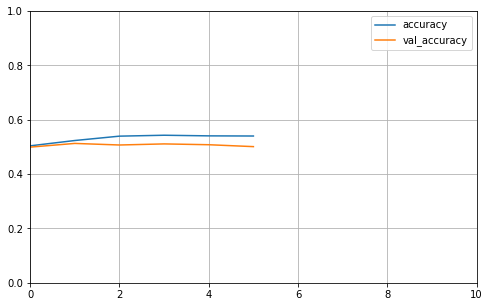

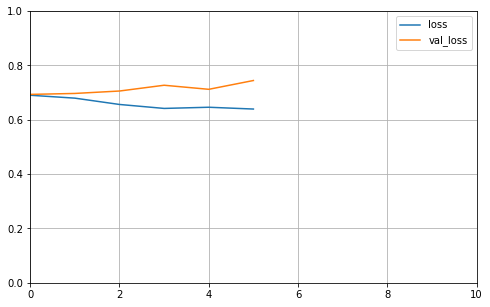

In [13]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history_single_rnn, 'accuracy', 10, 0, 1)
plot_learning_curves(history_single_rnn, 'loss', 10, 0, 1)

In [ ]:
single_rnn_model.evaluate(test_data, test_labels, batch_size = batch_size)

## 模型改进：多层双向RNN

In [15]:
embedding_dim = 16 # 每个词Embedding成长度为16的向量
batch_size = 128

rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64, return_sequences=False)),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])
rnn_model.summary()
rnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 128)          10368     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 203,393
Trainable params: 203,393
Non-trainable params: 0
_________________________________________________________________


In [16]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

# 训练
history_rnn = rnn_model.fit(
    train_data, train_labels, epochs = 30,batch_size = batch_size,
    validation_split = 0.2, callbacks = callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 219s 11ms/sample - loss: 0.6998 - accuracy: 0.4974 - val_loss: 0.6918 - val_accuracy: 0.5170
Epoch 2/30
20000/20000 [==============================] - 215s 11ms/sample - loss: 0.6507 - accuracy: 0.6105 - val_loss: 0.5681 - val_accuracy: 0.7308
Epoch 3/30
20000/20000 [==============================] - 216s 11ms/sample - loss: 0.5534 - accuracy: 0.7270 - val_loss: 0.4912 - val_accuracy: 0.7826
Epoch 4/30
20000/20000 [==============================] - 204s 10ms/sample - loss: 0.4965 - accuracy: 0.7726 - val_loss: 0.6554 - val_accuracy: 0.6634
Epoch 5/30
20000/20000 [==============================] - 209s 10ms/sample - loss: 0.5938 - accuracy: 0.6508 - val_loss: 0.7019 - val_accuracy: 0.4928
Epoch 6/30
20000/20000 [==============================] - 209s 10ms/sample - loss: 0.7038 - accuracy: 0.5017 - val_loss: 0.6980 - val_accuracy: 0.4980
Epoch 7/30
20000/20000 [=====================

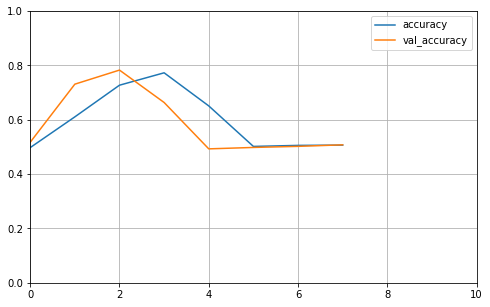

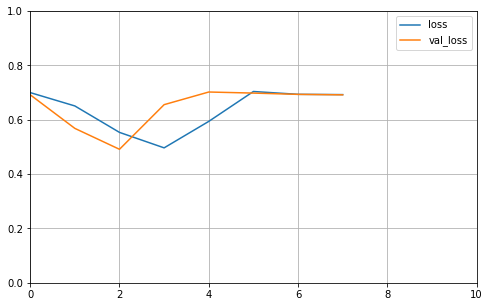

In [17]:
plot_learning_curves(history_rnn, 'accuracy', 10, 0, 1)
plot_learning_curves(history_rnn, 'loss', 10, 0, 1)

In [ ]:
rnn_model.evaluate(test_data, test_labels, batch_size = batch_size)

## 模型改进：单层双向RNN

In [9]:
embedding_dim = 16 # 每个词Embedding成长度为16的向量
batch_size = 128

bi_rnn_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(units=32, return_sequences=False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])
bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                3136      
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 165,249
Trainable params: 165,249
Non-trainable params: 0
_________________________________________________________________


In [10]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

# 训练
history_bi_rnn = bi_rnn_model.fit(
    train_data, train_labels, epochs = 30, batch_size = batch_size,
    validation_split = 0.2, callbacks = callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.6925 - accuracy: 0.5145 - val_loss: 0.6927 - val_accuracy: 0.5152
Epoch 2/30
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.6425 - accuracy: 0.6307 - val_loss: 0.4853 - val_accuracy: 0.7854
Epoch 3/30
20000/20000 [==============================] - 107s 5ms/sample - loss: 0.3953 - accuracy: 0.8249 - val_loss: 0.6731 - val_accuracy: 0.6438
Epoch 4/30
20000/20000 [==============================] - 104s 5ms/sample - loss: 0.2052 - accuracy: 0.9222 - val_loss: 0.5846 - val_accuracy: 0.7888
Epoch 5/30
20000/20000 [==============================] - 106s 5ms/sample - loss: 0.0686 - accuracy: 0.9791 - val_loss: 0.8638 - val_accuracy: 0.7566
Epoch 6/30
20000/20000 [==============================] - 105s 5ms/sample - loss: 0.0181 - accuracy: 0.9959 - val_loss: 0.9273 - val_accuracy: 0.7660
Epoch 7/30
20000/20000 [===========================

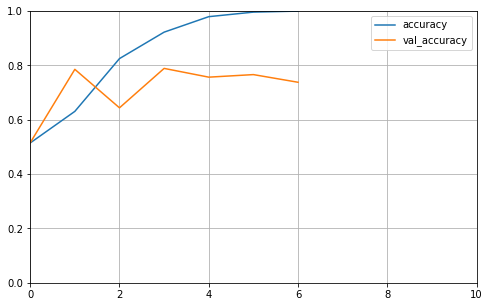

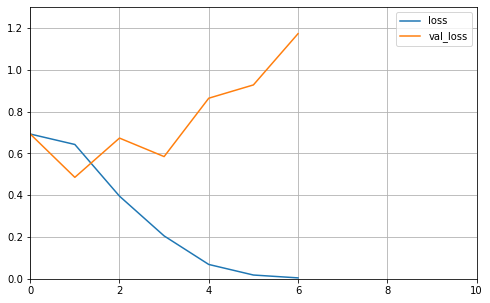

In [14]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()

plot_learning_curves(history_bi_rnn, 'accuracy', 10, 0, 1)
plot_learning_curves(history_bi_rnn, 'loss', 10, 0, 1.3)

In [15]:
bi_rnn_model.evaluate(test_data, test_labels, batch_size = batch_size)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.2352355475234986, 0.72132]